In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyximport
import matplotlib.collections as mcoll

pyximport.install(setup_args={'include_dirs': np.get_include()},reload_support=True)
from OverdampedLangevin3D_cython import Langevin3D 

from mpl_toolkits import mplot3d
from scipy.signal import correlate

import matplotlib.gridspec as gridspec


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140

mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.2
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
# rc('text', usetex=True)
rc('xtick', labelsize='x-small')
rc('ytick', labelsize='x-small')

# Langevin 3D, bulk, free particule

## I. Without inertia

<font color='blue'> Trajectory in 1D is writting by :

\begin{equation}
x(t+dt) = x(t) + a(x_{t}) \Delta B_{t} 
\end{equation}

$\underline{Creation~of~\textit{Langevin3D}~class.}$

$\textbf{Attributes of Langevin3D}$:
- dt: Time step [s].
- Nt: Number of time points.
- R: Radius of particule [m].
- eta: Fluid viscosity (default = 0.001 [Pa/s]).
- T: Temperature (default = 300 [k]).
- x0: Initial position of particule (default = (0,0,0) [m]).

$\textbf{Methodes of Langevin3D}$:

- Trajectory(output=False, Nt=None)
- plotTrajectory() 
- MSD1D(axis, output=False, plot=False)
- MSD3D(output=False, plot=False) 
- speedDistribution1D(axis, nbTimesIntervalle=1, bins=50, output=False, plot=False) 
- dXDistribution1D(axis, nbTimesIntervalle=1, bins=50, output=False, plot=False)</font>





### I.1 Trajectories

In [2]:
dt = 0.01
Nt = 500000+1
R = 1e-6
langevin3D = Langevin3D(dt, Nt, R)
langevin3D.trajectory()


<ipython-input-3-558f66f45d52>:15: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


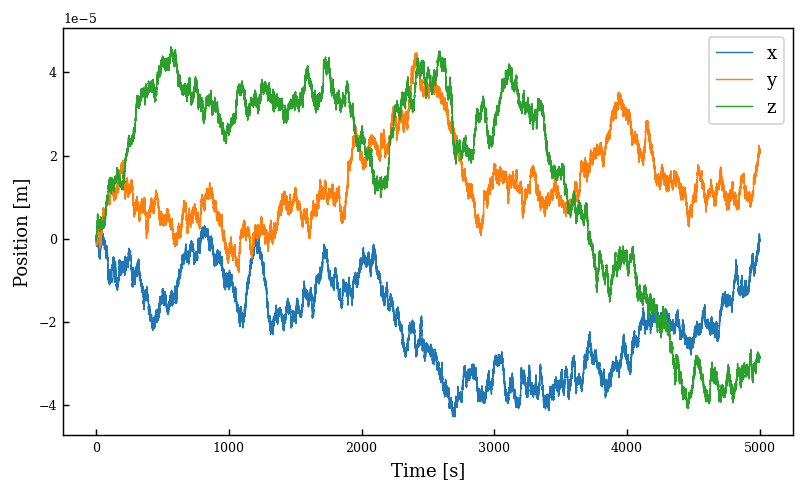

In [3]:
def cm2Inch(cm):
    inch = cm / 2.54
    return inch

w = cm2Inch(21 - 5)
h = cm2Inch((21 - 5)/1.618)
fig = plt.figure(constrained_layout=True, figsize=(w,h))
plt.plot(langevin3D.t, langevin3D.x, linewidth=0.8, label="x")
plt.plot(langevin3D.t, langevin3D.y, linewidth=0.8, label="y")
plt.plot(langevin3D.t, langevin3D.z, linewidth=0.8, label="z")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
# plt.savefig("trajOverdampedBulk.pdf")

In [4]:
def multicolored_lines():
       """
       http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
       http://matplotlib.org/examples/pylab_examples/multicolored_line.html
       """

       x = np.linspace(0, 4. * np.pi, 100)
       y = np.sin(x)
       fig, ax = plt.subplots()
       lc = colorline(x, y, cmap='hsv')
       plt.colorbar(lc)
       plt.xlim(x.min(), x.max())
       plt.ylim(-1.0, 1.0)
       plt.show()

def colorline(
           x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
           linewidth=3, alpha=1.0):
       """
       http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
       http://matplotlib.org/examples/pylab_examples/multicolored_line.html
       Plot a colored line with coordinates x and y
       Optionally specify colors in the array z
       Optionally specify a colormap, a norm function and a line width
       """

       # Default colors equally spaced on [0,1]:
       if z is None:
           z = np.linspace(0.0, 1.0, len(x))

       # Special case if a single number:
       # to check for numerical input -- this is a hack
       if not hasattr(z, "__iter__"):
           z = np.array([z])

       z = np.asarray(z)

       segments = make_segments(x, y)
       lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                                 linewidth=linewidth, alpha=alpha)

       ax = plt.gca()
       ax.add_collection(lc)

       return lc

### I.2 Mean square displacement 1D

<font color='blue'> The MSD 1D is compute like this :
\begin{equation}
<(x(t+dt)-x(t))^{2}> = \frac{1}{N} \sum (x(t+dt)-x(t))^{2}
\end{equation}</font>



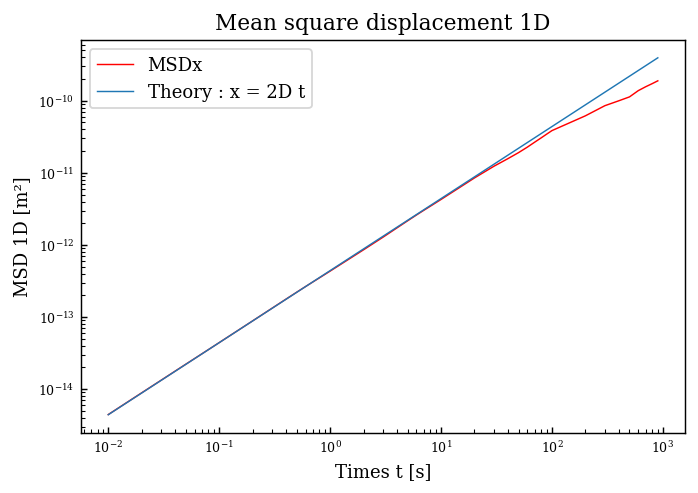

In [5]:
langevin3D.MSD1D("x", plot=True)

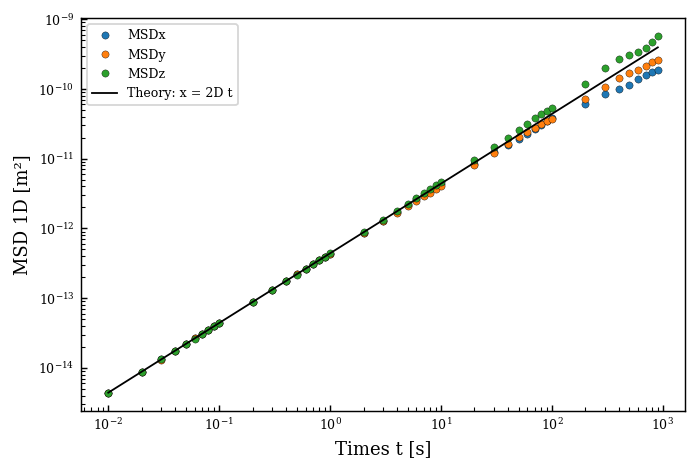

In [6]:
MSDx = langevin3D.MSD1D("x", output=True)
MSDy = langevin3D.MSD1D("y", output=True)
MSDz = langevin3D.MSD1D("z", output=True)

MSD1D = (2 * langevin3D.kb * langevin3D.T / langevin3D.gamma) * langevin3D.t[langevin3D.list_dt_MSD]

plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDx,
            "o", markersize=4,
            label="MSDx",
            )
plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDy,
            "o", markersize=4,
            label="MSDy",
            )
plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDz,
            "o", markersize=4,
            label="MSDz",
            )
plt.plot(langevin3D.t[langevin3D.list_dt_MSD],
         MSD1D,
         linewidth=1,
         color="black",
         label="Theory: x = 2D t",
        )
plt.xlabel("Times t [s]")
plt.ylabel("MSD 1D [m²]")
plt.legend(fontsize='x-small', loc='upper left')
plt.show()

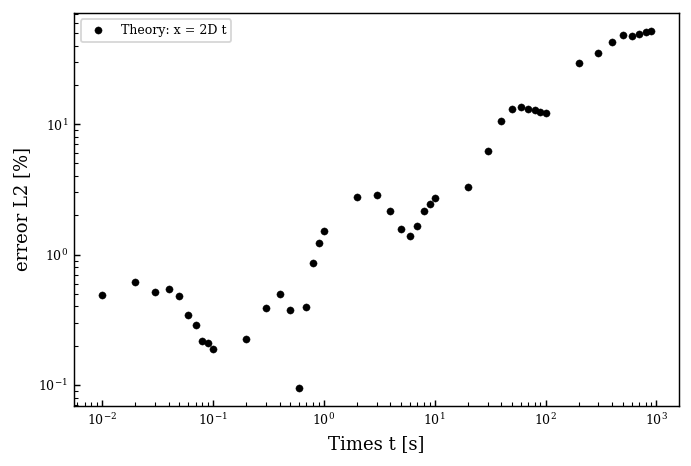

In [7]:
def normeErreurL2Relative(num, ana):
    f = (num - ana)**2/ana**2
    eL2 = np.sqrt(f) * 100
    
    return eL2

erreurL2MSDx = normeErreurL2Relative(MSDx, MSD1D)

plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
         erreurL2MSDx,
         "o", 
          markersize=4,
         color="black",
         label="Theory: x = 2D t",
        )
plt.xlabel("Times t [s]")
plt.ylabel("erreor L2 [%]")
plt.legend(fontsize='x-small', loc='upper left')
plt.show()

# erreurL2MSDy = normeErreurL2Relative(MSDy, MSD1D)
# print("Erreur L2 MSDy = ", erreurL2MSDy)

# erreurL2MSDz = normeErreurL2Relative(MSDz, MSD1D)
# print("Erreur L2 MSDz = ", erreurL2MSDz)

### I.3 Mean square displacement 3D

<font color='blue'> In 3D, MSD is compute like this :
\begin{equation}
<(\vec{x}(t+dt)-\vec{x}(t))^{2}> ~ = ~ <(x(t+dt)-x(t))^{2} ~ + ~ (y(t+dt)-y(t))^{2} ~ + ~ (z(t+dt)-z(t))^{2}>,
\end{equation}

as the coordinates are independent, we have:

\begin{equation}
<(\vec{x}(t+dt)-\vec{x}(t))^{2}> ~ = ~ <(x(t+dt)-x(t))^{2}> ~ + ~ <(y(t+dt)-y(t))^{2}> ~ + ~ <(z(t+dt)-z(t))^{2}>,
\end{equation}</font>



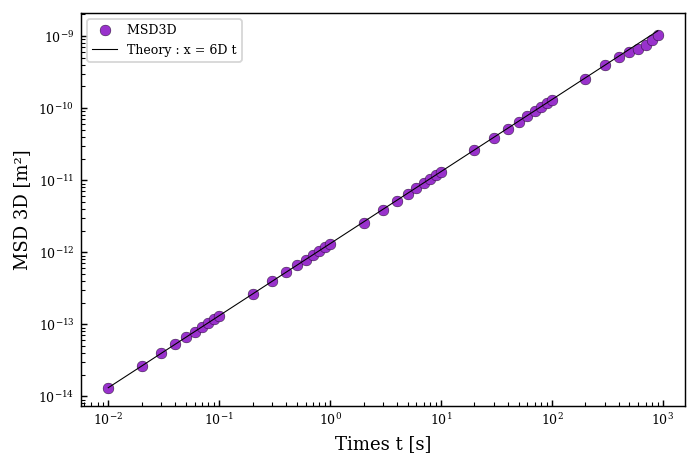

In [8]:
langevin3D.MSD3D(plot=True)

<font color='blue'>Same here between $10^{2}$ and $10^{3}$.</font>


### I.4. Dx distribution

In [9]:
# axis = "x"
# nbTimesIntervalle = [1, 10, 100]

# for i in nbTimesIntervalle:
#     hist, binsPosition = langevin3D.dXDistribution1D(axis, i, output=True)
#     plt.plot(binsPosition,hist, ".", label="$\Delta$ t = " + str(i*langevin3D.dt) + " s")
# plt.title("Probability density function 1D")
# plt.xlabel("$\\Delta$" + axis + " $[m]$")
# plt.ylabel("PDF $[m^{-1}.s]$")
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
# plt.legend()
# plt.show()

<font color='blue'> We can normalised speed by 

\begin{equation} 
\Delta x_{hist} = \frac{\Delta x}{\sqrt{2 D \Delta t }} 
\end{equation}

And we need to compute integrale between $] -\infty, +\infty[ $ to normalized y axis again.

Finaly, we can plot theory to compare :

\begin{equation} 
y_{theo} = \frac{1}{\sqrt{2 \pi}} e^{{- \frac{\Delta x_{hist}^{2}}{ 2} }}
\end{equation}

We can see next the result :</font>



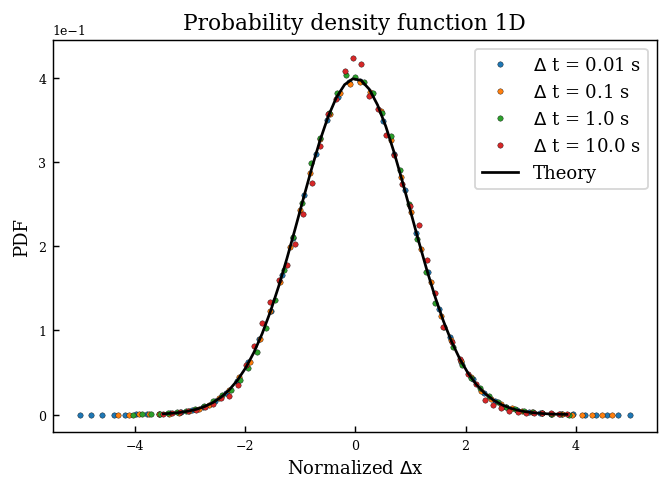

In [10]:
axis = "x"
nbTimesIntervalle = [1, 10, 100,1000]

for i in nbTimesIntervalle:
    hist, binsPosition = langevin3D.dXDistribution1D(axis, i, output=True)
    
    dx_hist = binsPosition/np.sqrt(2*langevin3D.D*langevin3D.dt*i)
    y_hist = hist
    normalisation_y = 1/np.trapz(y_hist,dx_hist)
    plt.plot(dx_hist,y_hist * normalisation_y, ".", label="$\Delta$ t = " + str(i*langevin3D.dt) + " s")

y_theo = 1/(np.sqrt(2*np.pi)) * np.exp(-(dx_hist**2)/2)
plt.plot(dx_hist, y_theo, "-", color="black", label="Theory")    
plt.title("Probability density function 1D")
plt.xlabel("Normalized $\\Delta$" + axis)
plt.ylabel("PDF")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend()
plt.show()

Non-inertial theory is avalayble for all times.

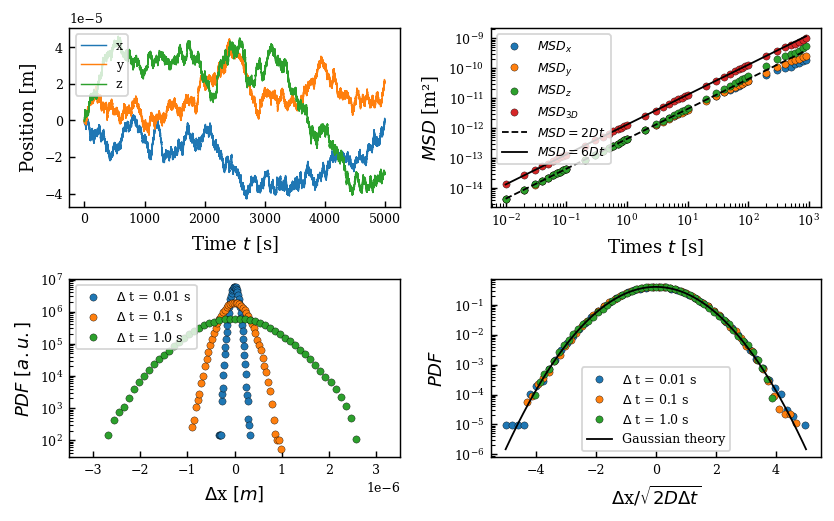

In [11]:
w = cm2Inch(21 - 5)
h = cm2Inch((21 - 5)/1.618)
fig = plt.figure(constrained_layout=True, figsize=(w,h))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

###################################################
fig.add_subplot(spec[0, 0])
plt.plot(langevin3D.t, langevin3D.x, linewidth=0.8, label="x")
plt.plot(langevin3D.t, langevin3D.y, linewidth=0.8, label="y")
plt.plot(langevin3D.t, langevin3D.z, linewidth=0.8, label="z")
plt.xlabel("Time $t$ [s]")
plt.ylabel("Position [m]")
plt.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
plt.legend(fontsize='x-small', loc="upper left")
###################################################
fig.add_subplot(spec[0, 1])

MSDx = langevin3D.MSD1D("x", output=True)
MSDy = langevin3D.MSD1D("y", output=True)
MSDz = langevin3D.MSD1D("z", output=True)
MSD3D = langevin3D.MSD3D(output=True)

plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDx,
            "o", markersize=4,
            label="$MSD_x$",
            )
plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDy,
            "o", markersize=4,
            label="$MSD_y$",
            )
plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDz,
            "o", markersize=4,
            label="$MSD_z$",
            )

plt.loglog(langevin3D.t[langevin3D.list_dt_MSD], langevin3D.MSD3, 
           "o",
           markersize=4, 
           label="$MSD_{3D}$ ")

plt.plot(langevin3D.t[langevin3D.list_dt_MSD],
         (2 * langevin3D.kb * langevin3D.T / langevin3D.gamma) * langevin3D.t[langevin3D.list_dt_MSD],
         "--",
         linewidth=1,
         color="black",
         label="$MSD = 2D t$",
        )
plt.plot(langevin3D.t[langevin3D.list_dt_MSD], 
         (2 * 3 * langevin3D.kb * langevin3D.T / langevin3D.gamma) * langevin3D.t[langevin3D.list_dt_MSD], 
         linewidth=1, 
         color="black", 
         label="$MSD = 6D t$")

plt.ylim([None, None])
plt.xlabel("Times $t$ [s]")
plt.ylabel("$MSD$ [m²]")
plt.legend(fontsize='x-small', loc='upper left')


###################################################
fig.add_subplot(spec[1, 0])

axe = "x"
nbTimesIntervalle = [1, 10, 100]

for i in nbTimesIntervalle:
    hist, binsPosition = langevin3D.dXDistribution1D(axe, i, output=True)
    plt.semilogy(binsPosition,hist, "o", markersize=4, label="$\Delta$ t = " + str(i*langevin3D.dt) + " s")
plt.xlabel("$\\Delta$" + axis + " $[m]$")
plt.ylabel("$PDF$ $[a.u.]$")
plt.legend(fontsize='x-small', loc='upper left')
plt.xlim([-3.5e-6, 3.5e-6])

###################################################
fig.add_subplot(spec[1, 1])

nbTimesIntervalle = [1, 10, 100]

for i in nbTimesIntervalle:
    hist, binsPosition = langevin3D.dXDistribution1D(axis, i, output=True)
    
    dx_hist = binsPosition/np.sqrt(2*langevin3D.D*langevin3D.dt*i)
    y_hist = hist
    normalisation_y = 1/np.trapz(y_hist,dx_hist)
    plt.plot(dx_hist,y_hist * normalisation_y, "o", markersize=4, label="$\Delta$ t = " + str(i*langevin3D.dt) + " s")

x_theo = np.linspace(-5, 5, 1000)
y_theo = 1/(np.sqrt(2*np.pi)) * np.exp(-(x_theo**2)/2)
plt.semilogy(x_theo, y_theo, "-", color="black", linewidth=1, label="Gaussian theory")
plt.xlabel("$\\Delta$" + axis +"$/\\sqrt{2D \\Delta t}$")
plt.ylabel("$PDF$")
plt.legend(fontsize='x-small', loc='lower center')


# plt.savefig("OverdampedBulk.svg")

## Plot 3D

Text(0.5, 0, '$z$ (m)')

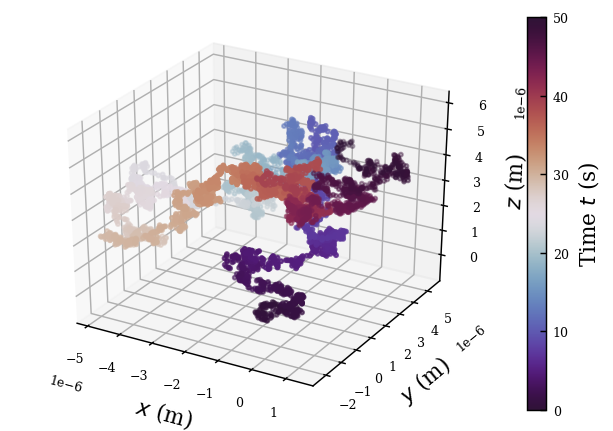

In [12]:
from mpl_toolkits.mplot3d import Axes3D

N = int((langevin3D.Nt-1)/100) + 1
x = langevin3D.x[0:N]
y = langevin3D.y[0:N]
z = langevin3D.z[0:N]
t = langevin3D.t[0:N]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pnt3d=ax.scatter(x, y, z, c=t, cmap='twilight_shifted', marker=".")

cbar=plt.colorbar(pnt3d)
cbar.set_label("Time $t$ (s)", fontsize=12)
ax.set_xlabel("$x$ (m)", fontsize=12, rotation=-30)
ax.set_ylabel("$y$ (m)", fontsize=12, rotation= 60)
ax.set_zlabel("$z$ (m)", fontsize=12, rotation=0)
# plt.savefig("mouvementBro.svg")